In [1]:
%pip install openai -q -U

In [2]:
import os
import json
import spacy
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, HDBSCAN, AgglomerativeClustering

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
azure_client: openai.AzureOpenAI|None = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  azure_client = openai.AzureOpenAI(
      azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
      api_version=userdata.get('OPENAI_API_VERSION'),
      api_key=userdata.get('AZURE_OPENAI_API_KEY'),
  )

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [5]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
)
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str
15591405,2015-01-26 22:19:00,469,5290,8.2,"""Chip Transaction""",61195,"""Placentia""","""CA""",92870.0,"""5541""",null,"""Service Stations""","""No""",67,67,1952,3,"""Female""","""488 Bayview Boulevard""",33.88,-117.85,26675.0,46945.0,17835.0,682,4,"""Mastercard""","""Debit""",5317963113167475,"""08/2023""",60,"""YES""",1,26162.0,"""10/2014""",2014,"""No""","""No""","""Placentia""","""United States"""
20436664,2017-11-26 10:34:00,949,2249,4.9,"""Chip Transaction""",91845,"""North Brunswick""","""NJ""",8902.0,"""5912""",null,"""Drug Stores and Pharmacies""","""No""",29,71,1990,11,"""Female""","""6595 Ocean Drive""",40.45,-74.48,31234.0,63684.0,96864.0,709,5,"""Mastercard""","""Debit""",5026926528558439,"""06/2023""",88,"""YES""",2,15813.0,"""03/2010""",2011,"""No""","""No""","""North Brunswick""","""United States"""
8081243,2010-06-01 20:02:00,1920,2791,75.87,"""Swipe Transaction""",46474,"""Ogilvie""","""MN""",56358.0,"""7538""",null,"""Automotive Service Shops""","""No""",64,66,1955,7,"""Male""","""3315 Lake Lane""",46.04,-95.29,15325.0,31244.0,51924.0,713,4,"""Visa""","""Debit""",4515665907154914,"""06/2020""",91,"""NO""",2,20318.0,"""05/1996""",2015,"""No""","""No""","""Ogilvie""","""United States"""
23385633,2019-08-12 22:50:00,1148,3128,48.45,"""Chip Transaction""",69972,"""Philadelphia""","""PA""",19145.0,"""5814""","""Bad PIN""","""Fast Food Restaurants""","""No""",54,70,1965,4,"""Male""","""377 Lake Lane""",39.95,-75.16,18007.0,36711.0,47490.0,687,4,"""Visa""","""Debit""",4536763812166738,"""01/2021""",475,"""YES""",1,11068.0,"""05/2012""",2012,"""No""","""No""","""Philadelphia""","""United States"""
9314095,2011-03-24 07:12:00,1424,4710,18.53,"""Swipe Transaction""",26810,"""Sedona""","""AZ""",86351.0,"""5541""",null,"""Service Stations""","""No""",101,68,1918,5,"""Female""","""887 Third Boulevard""",35.13,-112.99,13086.0,15348.0,1396.0,761,4,"""Mastercard""","""Credit""",5033949193863455,"""05/2021""",76,"""YES""",2,8000.0,"""09/2009""",2011,"""No""","""No""","""Sedona""","""United States"""


In [6]:
def floor_to_15min(dt_value: datetime) -> datetime|None:
    if dt_value is None:
        return None

    seconds_since_midnight = (dt_value - dt_value.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    interval_seconds = 15 * 60
    floored_seconds = (seconds_since_midnight // interval_seconds) * interval_seconds
    return dt_value.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=floored_seconds)

In [7]:
df = df.with_columns(
    pl.col("date").map_elements(floor_to_15min, return_dtype=pl.Datetime).alias("date_window")
)

In [8]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).mean().alias(f'mean_{column_name}'),
        pl.col(column_name).std().alias(f'std_{column_name}'),
        pl.col(column_name).skew().alias(f'skew_{column_name}'),
        pl.col(column_name).kurtosis().alias(f'kurtosis_{column_name}')
    ]

In [9]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [10]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [11]:
def list_structs_to_dict(list_of_structs, column_name):
  if list_of_structs is None:
      return None

  items = {}
  for item in list_of_structs:
    key = item[column_name]
    value = round(item['proportion'], 2)
    items[key] = value

  return items

def convert_categorical_to_percent(df: pl.DataFrame, column_name: str, group_by_column) -> pl.DataFrame:
  list_structs_to_dict_column = lambda items: list_structs_to_dict(items, column_name)

  df_group = df.group_by(group_by_column).agg(pl.col(column_name).value_counts(normalize=True)).sort(group_by_column)

  df_fields = df_group.with_columns(
    pl.col(column_name).map_elements(
        list_structs_to_dict_column,
        return_dtype=pl.Object
  ).alias(column_name))

  fields = df_fields[column_name].to_list()
  data = pd.DataFrame(fields).fillna(0.0)
  data.columns = [f'{column_name}_{col.lower().replace(" ", "_")}' for col in data.columns]
  # data[group_by_column] = df_fields[group_by_column].to_list()
  data = pl.from_pandas(data)
  data = data.with_columns(df_fields[group_by_column].alias(group_by_column))
  return data

In [12]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726


In [13]:
for column in ['use_chip', 'gender', 'card_brand', 'card_type', 'has_chip', 'online_sales']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,use_chip_chip_transaction,gender_female,gender_male,card_brand_visa,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_credit,card_type_debit,card_type_debit_(prepaid),has_chip_yes,has_chip_no,online_sales_yes,online_sales_no
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.83,0.0,0.33,0.67,0.17,0.83,0.0,0.0,0.17,0.33,0.5,1.0,0.0,0.17,0.83
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,1.0,0.0,0.25,0.75,0.75,0.25,0.0,0.0,0.0,0.75,0.25,0.75,0.25,0.0,1.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.8,0.0,0.5,0.5,0.2,0.8,0.0,0.0,0.4,0.6,0.0,1.0,0.0,0.2,0.8
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.83,0.0,0.5,0.5,0.33,0.5,0.17,0.0,0.17,0.67,0.17,1.0,0.0,0.17,0.83
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.67,0.33,0.17,0.83,0.0,0.0,0.33,0.67,0.0,1.0,0.0,0.5,0.5
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771215,23935.4,3065.888664,0.013807,-0.528075,81437.8,28100.092281,1.039823,-0.491354,754.0,56.178288,1.098869,-0.206714,3.0,1.0,0.0,-1.75,14693.8,4012.619369,-0.062165,-1.724288,0.0,1.0,0.0,0.8,0.2,0.4,0.6,0.0,0.0,0.4,0.6,0.0,0.8,0.2,0.0,1.0
2010-01-01 01:30:00,4,0,17.535,17.586155,0.425266,-1.453984,67.0,20.314199,0.318187,-1.563732,25778.5,6119.646749,-0.905558,-0.842706,30717.5,34917.933869,0.121262,-1.83475,747.0,52.36411,0.19568,-1.262078,6.25,0.5,1.154701,-0.666667,24618.5,11453.384085,0.474271,-1.360883,0.0,1.0,0.0,1.0,0.0,0.0,0.75,0.25,0.0,0.25,0.75,0.0,1.0,0.0,0.0,1.0
2010-01-01 01:45:00,7,0,51.992857,34.98547,1.019653,-0.01202,56.428571,11.544943,-0.075079,-1.292404,25930.0,12385.902524,1.407045,0.814717,51734.285714,42299.149521,0.614604,-0.406747,726.285714,37.187427,-0.51775,-0.245965,4.285714,1.704336,-0.040073,-1.64781,21924.571429,25060.956213,1.683264,1.455575,0.43,0.57,0.0,0.57,0.43,0.29,0.57,0.14,0.0,0.14,0.71,0.14,1.0,0.0,0.43,0.57
2010-01-01 02:00:00,9,0,45.843333,68.940091,1.30041,0.377724,50.0,21.75431,1.6103

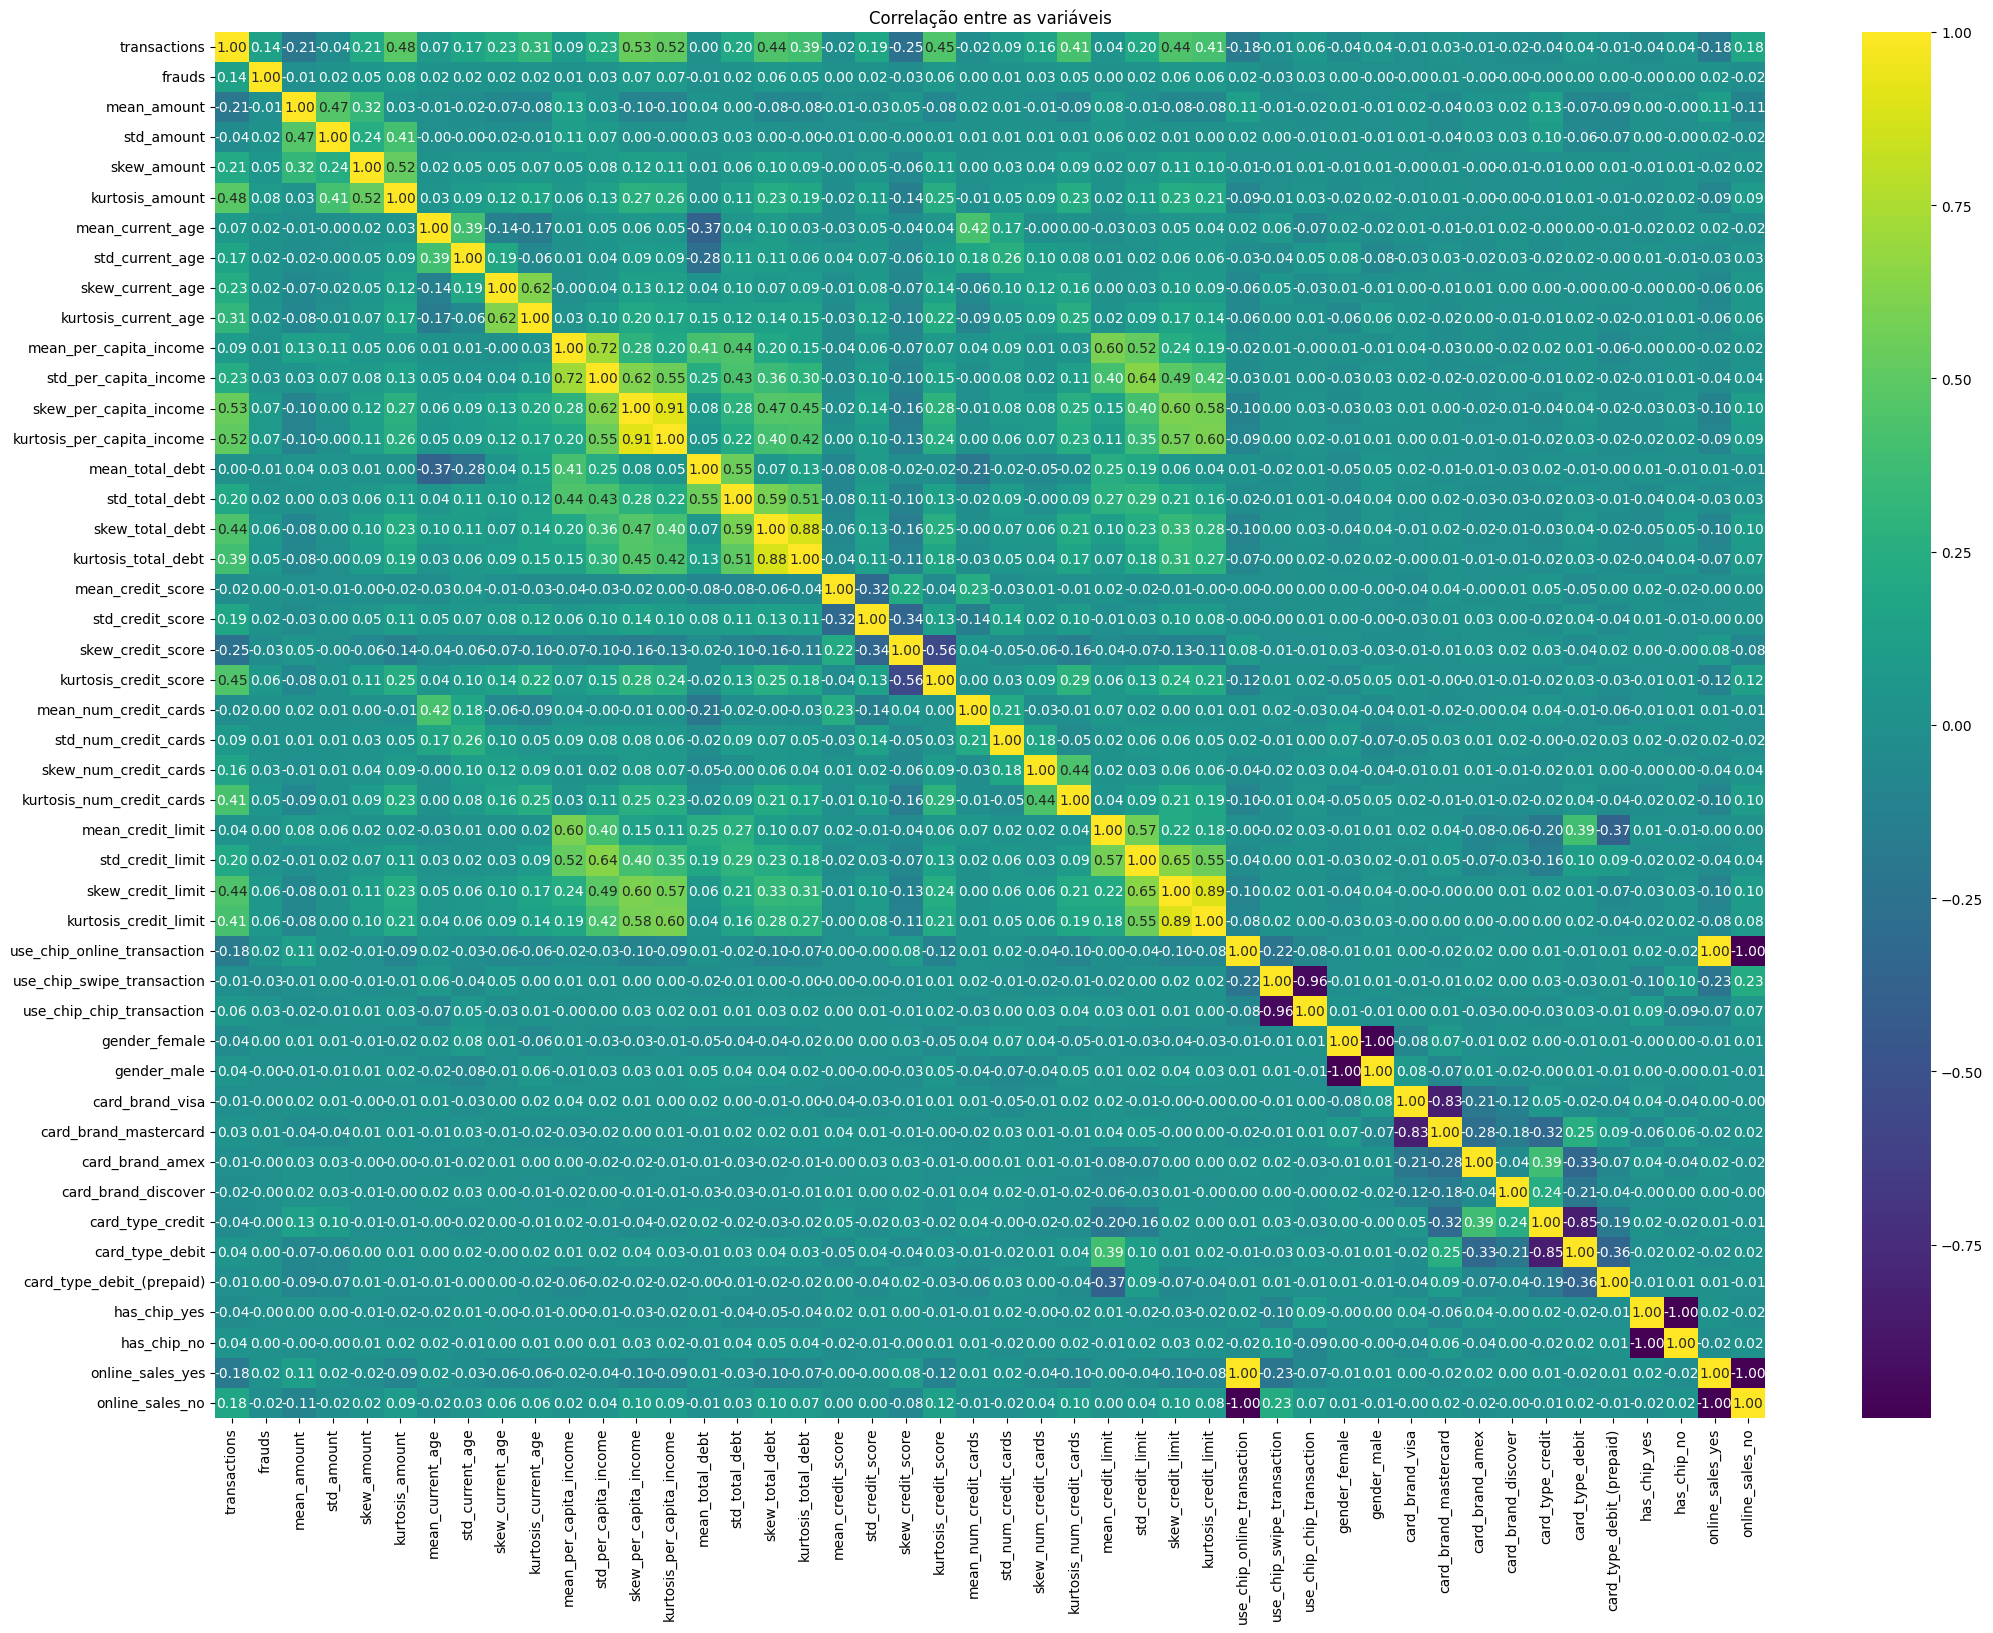

In [15]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(25,18))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [16]:
df_proportion = df['description'].value_counts(normalize=True).sort('proportion', descending=True)
df_proportion.head()

description,proportion
str,f64
"""Grocery Stores, Supermarkets""",0.119668
"""Miscellaneous Food Stores""",0.10986
"""Service Stations""",0.107137
"""Eating Places and Restaurants""",0.075133
"""Drug Stores and Pharmacies""",0.058037


In [17]:
df_proportion.shape

(108, 2)

In [18]:
df_proportion = df.group_by("description").agg([
    pl.len().alias("transaction_count"),
    pl.col("target").sum().alias("frauds"),
    pl.sum("amount").alias("total_amount"),
]).join(df_proportion, on='description', how='left')

In [19]:
df_proportion.filter(pl.col('proportion') >= 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.870067,7315


In [20]:
df_proportion.filter(pl.col('proportion') < 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.129933,6017


In [21]:
# df['description'].unique().to_list()

In [22]:
# categories = pl.DataFrame(df['description'].unique())
# categories.columns = ['description']
# categories.head()

In [23]:
# nlp = spacy.load('en_core_web_sm')

In [24]:
# def remove_stop_words(text):
#     doc = nlp(text)
#     return ' '.join([token.lemma_ for token in doc if not token.is_stop or not token.is_punct]).lower()

In [25]:
# # Convert text to radical and remove stop word and set lower text
# categories = categories.with_columns(
#     pl.col('description').map_elements(remove_stop_words).alias('description_process')
# )
# categories.head()

In [26]:
# categories['description'].to_list()

In [27]:
# categories = categories.with_columns(
#     pl.col('description').map_elements(lambda x: nlp(x).vector).alias('vetor')
# )
# categories.head()

In [28]:
# def calcular_qtd_clusters(data, max_clusters=10, plot=True):
#     """
#     Calcula a quantidade ideal de clusters usando o método do cotovelo e o índice de silhueta.

#     Parâmetros:
#     - data: array-like, dados de entrada (já reduzidos com PCA se necessário).
#     - max_clusters: número máximo de clusters a testar.
#     - plot: se True, plota os gráficos de avaliação.

#     Retorna:
#     - dicionário com inércia e silhouette para cada K.
#     """
#     inercia = []
#     silhueta = []
#     k_range = range(2, max_clusters + 1)

#     for k in k_range:
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         labels = kmeans.fit_predict(data)
#         inercia.append(kmeans.inertia_)
#         silhueta.append(silhouette_score(data, labels))

#     if plot:
#         fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#         ax[0].plot(k_range, inercia, marker='o')
#         ax[0].set_title('Método do Cotovelo')
#         ax[0].set_xlabel('Número de Clusters')
#         ax[0].set_ylabel('Inércia')

#         ax[1].plot(k_range, silhueta, marker='o', color='green')
#         ax[1].set_title('Índice de Silhueta')
#         ax[1].set_xlabel('Número de Clusters')
#         ax[1].set_ylabel('Silhouette Score')

#         plt.tight_layout()
#         plt.show()

#     return {
#         "inercia": dict(zip(k_range, inercia)),
#         "silhouette": dict(zip(k_range, silhueta))
#     }

In [29]:
# pca = PCA(n_components=90)
# components = pca.fit_transform(categories['vetor'].to_list())

In [30]:
# normalized_components = normalize(components, axis=1)

In [31]:
# explained_variance_ratio_per_component = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(explained_variance_ratio_per_component)

# gain_marginal = explained_variance_ratio_per_component

# block_size = 10
# num_components = len(gain_marginal)
# num_blocks = (num_components + block_size - 1) // block_size # Garante que o último bloco seja incluído

# block_means = []
# block_indices = []

# for i in range(num_blocks):
#     start_index = i * block_size
#     end_index = min((i + 1) * block_size, num_components)

#     if start_index < num_components: # Garante que haja componentes no bloco
#         current_block_gain = gain_marginal[start_index:end_index]
#         block_means.append(np.mean(current_block_gain))
#         block_indices.append(f'{start_index+1}-{end_index}')

In [32]:
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o', linestyle='-')
# plt.title('Variância Explicada Cumulativa')
# plt.xlabel('Número de Componentes')
# plt.ylabel('Variância Explicada Cumulativa')
# plt.grid(True)
# plt.xticks(range(0, 101, 10))
# plt.axhline(y=0.90, color='r', linestyle='--', label='90% de Variância Explicada')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.bar(block_indices, block_means, color='skyblue')
# plt.title(f'Média do Ganho Marginal de Variância por Bloco de {block_size} Componentes')
# plt.xlabel(f'Bloco de Componentes (1-{block_size}, {block_size+1}-{2*block_size}, etc.)')
# plt.ylabel('Média do Ganho Marginal de Variância')
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()

In [33]:
# # Análise numérica para identificar o "cotovelo"
# print("\nAnálise da Média do Ganho Marginal por Bloco:")
# for i, mean_gain in enumerate(block_means):
#     print(f"Bloco {block_indices[i]}: Média do Ganho = {mean_gain:.4f}")

# # Exemplo de critério de parada (pode ser ajustado)
# threshold_gain = 0.05 # Por exemplo, se o ganho médio cair abaixo de 0.5%
# chosen_components = 0
# for i in range(num_blocks):
#     if block_means[i] < threshold_gain and i > 0: # Para evitar parar muito cedo
#         chosen_components = i * block_size
#         print(f"\nO ganho médio caiu abaixo de {threshold_gain:.4f} no bloco {block_indices[i]}.")
#         print(f"Número sugerido de componentes (aproximado): {chosen_components}")
#         break
#     if i == num_blocks - 1 and chosen_components == 0: # Se o limiar nunca foi atingido
#         print(f"\nNenhum bloco teve ganho médio abaixo de {threshold_gain:.4f}. Considere aumentar o limiar ou analisar o gráfico.")

In [34]:
# n_components = chosen_components

In [35]:
# result = calcular_qtd_clusters(normalized_components[:, :n_components], plot=True)

In [36]:
# n_clusters = list(result['silhouette'].keys())[np.argmax(list(result['silhouette'].values()))]
# n_clusters

In [37]:
# kmeans = KMeans(n_clusters=10, random_state=42)
# labels = kmeans.fit_predict(normalized_components[:, :n_components])
# centroids = kmeans.cluster_centers_

In [38]:
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(normalized_components[:, 0], normalized_components[:, 1], c=labels, cmap='viridis', alpha=0.6, s=30)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
# plt.title('Clusters no Espaço dos 2 Primeiros Componentes do PCA')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [39]:
# df_proportion = df_proportion.with_columns(
#     pl.lit(labels).alias('cluster')
# )
# df_proportion.head()

In [40]:
# df_proportion.group_by('cluster').agg([
#     pl.col('description').map_batches(lambda x: ', '.join(x)).alias('description'),
# ])

In [41]:
# hdbscan = HDBSCAN(metric='cosine')
# labels = hdbscan.fit_predict(categories['vetor'].to_list())

In [42]:
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(normalized_components[:, 0], normalized_components[:, 1], c=labels, cmap='viridis', alpha=0.6, s=30)
# plt.title('Clusters no Espaço dos 2 Primeiros Componentes do PCA')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [43]:
# labels

In [44]:
# df_proportion = df_proportion.with_columns(
#     pl.lit(labels).alias('cluster-db')
# )
# df_proportion.head()

In [45]:
# df_proportion.group_by('cluster-db').agg([
#     pl.col('description').map_batches(lambda x: ', '.join(x)).alias('description'),
# ])

In [46]:
# aglo = AgglomerativeClustering(n_clusters=10)
# labels = aglo.fit_predict(normalized_components)

In [47]:
# df_proportion = df_proportion.with_columns(
#     pl.lit(labels).alias('aglo')
# )
# df_proportion.head()

In [48]:
# df_proportion.group_by('aglo').agg([
#     pl.col('description').map_batches(lambda x: ', '.join(x)).alias('description'),
# ])

In [49]:
prompt = """
Por favor, agrupe as seguintes categorias de negócios e serviços em conjuntos homogêneos. Cada grupo deve ser semanticamente coeso internamente e claramente distinto dos outros grupos (heterogêneo entre si).

Para cada grupo identificado, forneça um nome descritivo e conciso que capture a essência dos itens pertencentes a ele.

---
FORMATO DE SAÍDA OBRIGATÓRIO:
Sua resposta deve ser uma lista de objetos JSON. Cada objeto representa um grupo e deve conter as seguintes chaves:
- `cluster`: Uma string, o nome descritivo do grupo.
- `items`: Uma lista de strings, contendo as categorias de negócios que pertencem a este grupo.

---
EXEMPLO ILUSTRATIVO DE SAÍDA ESPERADA (ESTRUTURA):
```json
[
  {
    "cluster": "Saúde e Bem-Estar",
    "items": ["Hospitais", "Clínicas Médicas", "Farmácias"]
  },
  {
    "cluster": "Varejo Alimentício",
    "items": ["Supermercados", "Padarias", "Açougues"]
  }
]
```

---
DADOS DE ENTRADA:

@dados
""".replace("@dados", str.join('\n', df['description'].unique()))
prompt

'\nPor favor, agrupe as seguintes categorias de negócios e serviços em conjuntos homogêneos. Cada grupo deve ser semanticamente coeso internamente e claramente distinto dos outros grupos (heterogêneo entre si).\n\nPara cada grupo identificado, forneça um nome descritivo e conciso que capture a essência dos itens pertencentes a ele.\n\n---\nFORMATO DE SAÍDA OBRIGATÓRIO:\nSua resposta deve ser uma lista de objetos JSON. Cada objeto representa um grupo e deve conter as seguintes chaves:\n- `cluster`: Uma string, o nome descritivo do grupo.\n- `items`: Uma lista de strings, contendo as categorias de negócios que pertencem a este grupo.\n\n---\nEXEMPLO ILUSTRATIVO DE SAÍDA ESPERADA (ESTRUTURA):\n```json\n[\n  {\n    "cluster": "Saúde e Bem-Estar",\n    "items": ["Hospitais", "Clínicas Médicas", "Farmácias"]\n  },\n  {\n    "cluster": "Varejo Alimentício",\n    "items": ["Supermercados", "Padarias", "Açougues"]\n  }\n]\n```\n\n---\nDADOS DE ENTRADA:\n\nPottery and Ceramics\nDentists and Orth

In [50]:
response = azure_client.chat.completions.create(
    messages=[
         {
             "role": "system",
             "content": """
              Você é um especialista em taxonomia e agrupamento de negócios, com vasto conhecimento sobre diversos setores da indústria e serviços. Sua principal tarefa é categorizar e organizar informações de forma lógica e coerente.
              Sua resposta deve ser estritamente no formato JSON. Não inclua texto introdutório, conclusivo ou qualquer explicação adicional antes ou depois do JSON. Mantenha a resposta concisa e direta, focando apenas no resultado final.
              Garanta que todos itens estejam dentro do JSON em algum grupo.
              """
         },
         {"role": "user", "content": prompt}
    ],
    model='o1',
    response_format={"type": "json_object"},
    max_completion_tokens=16000
)
response_data = json.loads(response.choices[0].message.content)

In [51]:
assert len(df['description'].unique()) == len(sum(list(map(lambda x: x['items'], response_data['groups'])), []))

In [52]:
categories_cluster = sum(list(map(lambda x: [dict(category=x['cluster'], description=item) for item in x['items']], response_data['groups'])), [])
categories_cluster = pl.DataFrame(categories_cluster)
categories_cluster.head()

category,description
str,str
"""Healthcare & Medical""","""Dentists and Orthodontists"""
"""Healthcare & Medical""","""Doctors, Physicians"""
"""Healthcare & Medical""","""Optometrists, Optical Goods an…"
"""Healthcare & Medical""","""Medical Services"""
"""Healthcare & Medical""","""Podiatrists"""


In [53]:
categories_cluster

category,description
str,str
"""Healthcare & Medical""","""Dentists and Orthodontists"""
"""Healthcare & Medical""","""Doctors, Physicians"""
"""Healthcare & Medical""","""Optometrists, Optical Goods an…"
"""Healthcare & Medical""","""Medical Services"""
"""Healthcare & Medical""","""Podiatrists"""
…,…
"""Entertainment, Recreation & Le…","""Recreational Sports, Clubs"""
"""Entertainment, Recreation & Le…","""Athletic Fields, Commercial Sp…"
"""Entertainment, Recreation & Le…","""Motion Picture Theaters"""


In [56]:
df = df.join(categories_cluster, on='description', how='left')
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""",0,30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No""","""No""","""Beulah""","""United States""",2010-01-01 00:00:00,"""Food & Beverage"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""",0,48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No""","""No""","""Bettendorf""","""United States""",2010-01-01 00:00:00,"""Retail General Merchandise"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""",0,49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No""","""No""","""Vista""","""United States""",2010-01-01 00:00:00,"""Professional & Financial Servi…"
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…",0,51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No""","""No""","""Harwood""","""United States""",2010-01-01 00:00:00,"""Food & Beverage"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""",0,47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No""","""No""","""Bronx""","""United States""",2010-01-01 00:00:00,"""Miscellaneous Retail & Special…"


In [58]:
for column in ['category']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,use_chip_chip_transaction,gender_female,gender_male,card_brand_visa,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_credit,card_type_debit,card_type_debit_(prepaid),has_chip_yes,has_chip_no,online_sales_yes,online_sales_no,category_food_&_beverage,category_miscellaneous_retail_&_specialty,category_retail_general_merchandise,category_transportation_&_travel,category_professional_&_financial_services,category_automotive_&_vehicle_services,category_technology_&_telecommunication,category_government_&_utilities,"category_entertainment,_recreation_&_leisure",category_hospitality_&_lodging,category_security_&_investigative_services,category_healthcare_&_medical,category_retail_clothing_&_apparel,category_personal_&_household_services,category_home_improvement_&_furnishing,category_industrial_&_metalworks,category_construction_&_contracting
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.83,0.0,0.33,0.67,0.17,0.83,0.0,0.0,0.17,0.33,0.5,1.0,0.0,0.17,0.83,0.33,0.17,0.17,0.17,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,1.0,0.0,0.25,0.75,0.75,0.25,0.0,0.0,0.0,0.75,0.25,0.75,0.25,0.0,1.0,0.5,0.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.8,0.0,0.5,0.5,0.2,0.8,0.0,0.0,0.4,0.6,0.0,1.0,0.0,0.2,0.8,0.3,0.0,0.0,0.2,0.1,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.83,0.0,0.5,0.5,0.33,0.5,0.17,0.0,0.17,0.67,0.17,1.0,0.0,0.17,0.83,0.67,0.0,0.17,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.67,0.33,0.17,0.83,0.0,0.0,0.33,0.67,0.0,1.0,0.0,0.5,0.5,0.33,0.0,0.0,0.17,0.0,0.0,0.17,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771

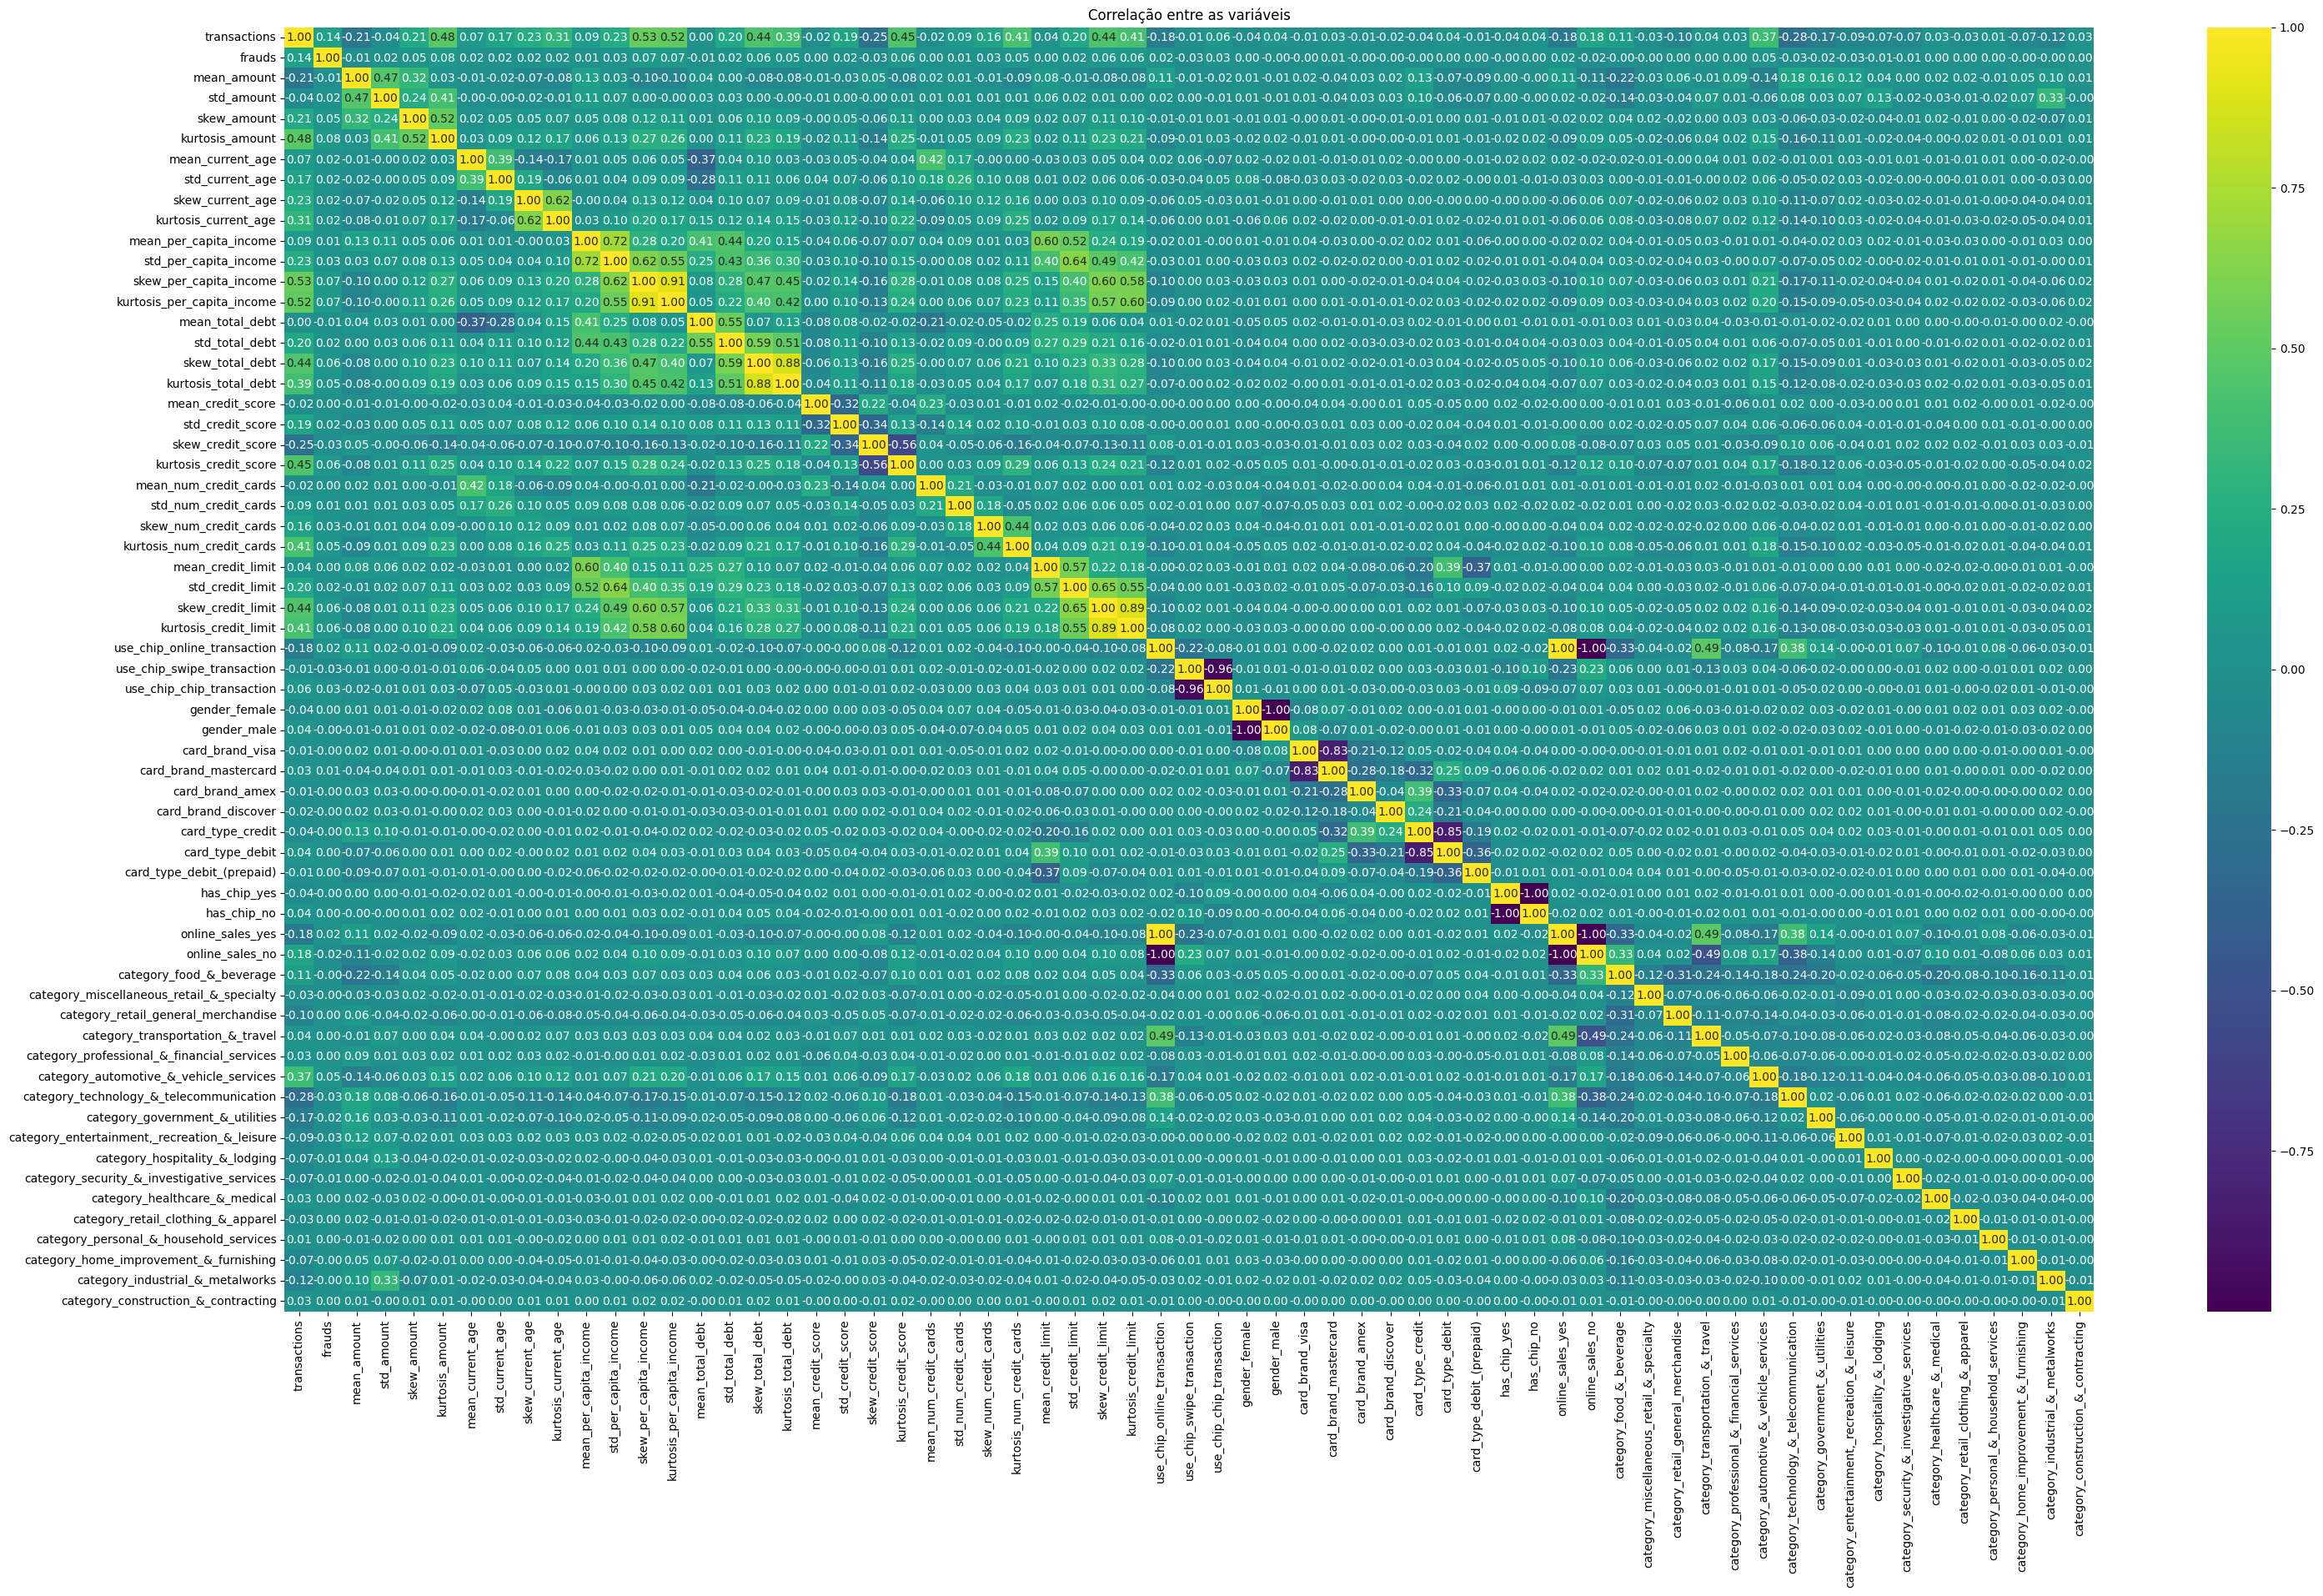

In [61]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()